In [17]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
from glob import glob
from datetime import datetime, timedelta
import os

# Set style
plt.style.use('seaborn-v0_8-whitegrid')

## 1. Load the Processed ApRES Data

The raw ApRES data has already been processed to extract range-over-time information and saved in `rangeOverTime.mat`.

In [18]:
# Load the processed ApRES data
mat_file = '../data/apres/rangeOverTime.mat'

if os.path.exists(mat_file):
    apres_data = sio.loadmat(mat_file)
    print("Successfully loaded rangeOverTime.mat")
    print(f"\nVariables in file:")
    for key in apres_data.keys():
        if not key.startswith('_'):
            val = apres_data[key]
            if hasattr(val, 'shape'):
                print(f"  {key}: shape = {val.shape}, dtype = {val.dtype}")
            else:
                print(f"  {key}: {type(val)}")
else:
    print(f"File not found: {mat_file}")

Successfully loaded rangeOverTime.mat

Variables in file:
  range: shape = (181, 1), dtype = float64
  timeInDays: shape = (181, 1), dtype = float64


In [19]:
# Extract the main variables
# The exact variable names depend on the MATLAB output
# Let's explore what we have

for key in apres_data.keys():
    if not key.startswith('_'):
        print(f"\n=== {key} ===")
        val = apres_data[key]
        if hasattr(val, 'shape'):
            print(f"Shape: {val.shape}")
            if val.size < 20:
                print(f"Values: {val}")
            elif len(val.shape) == 1 or (len(val.shape) == 2 and min(val.shape) == 1):
                flat = val.flatten()
                print(f"First 5: {flat[:5]}")
                print(f"Last 5: {flat[-5:]}")
                print(f"Min: {np.nanmin(flat):.6f}, Max: {np.nanmax(flat):.6f}")


=== range ===
Shape: (181, 1)
First 5: [1094.05373424 1094.06752697 1094.07042907 1094.10495201 1094.15694163]
Last 5: [1095.50420939 1095.50460352 1095.50432224 1095.50583207 1095.50518175]
Min: 1094.053734, Max: 1095.505832

=== timeInDays ===
Shape: (181, 1)
First 5: [47.1049 49.2749 49.6049 55.7749 64.1049]
Last 5: [328.2949 328.4549 328.6249 328.7949 328.9549]
Min: 47.104900, Max: 328.954900


## 2. Overview of Raw ApRES Files

Let's also look at the raw data files to understand the temporal coverage.

In [20]:
# List raw ApRES data files
raw_files = sorted(glob('../data/apres/raw/DATA*.DAT'))
print(f"Total number of raw ApRES files: {len(raw_files)}")

# Parse dates from filenames
def parse_apres_filename(filename):
    """Parse date and time from ApRES filename like DATA2019-01-18-0231.DAT"""
    basename = os.path.basename(filename)
    # Extract date parts: DATA2019-01-18-0231.DAT
    parts = basename.replace('DATA', '').replace('.DAT', '').split('-')
    year, month, day = int(parts[0]), int(parts[1]), int(parts[2])
    time_str = parts[3]
    hour, minute = int(time_str[:2]), int(time_str[2:])
    return datetime(year, month, day, hour, minute)

# Get all dates
dates = [parse_apres_filename(f) for f in raw_files]
print(f"\nDate range: {min(dates)} to {max(dates)}")
print(f"Duration: {(max(dates) - min(dates)).days} days")

# Calculate average sampling interval
intervals = [(dates[i+1] - dates[i]).total_seconds() / 3600 for i in range(len(dates)-1)]
print(f"Average sampling interval: {np.mean(intervals):.1f} hours")

Total number of raw ApRES files: 1878

Date range: 2019-01-18 02:31:00 to 2019-11-25 23:02:00
Duration: 311 days
Average sampling interval: 4.0 hours


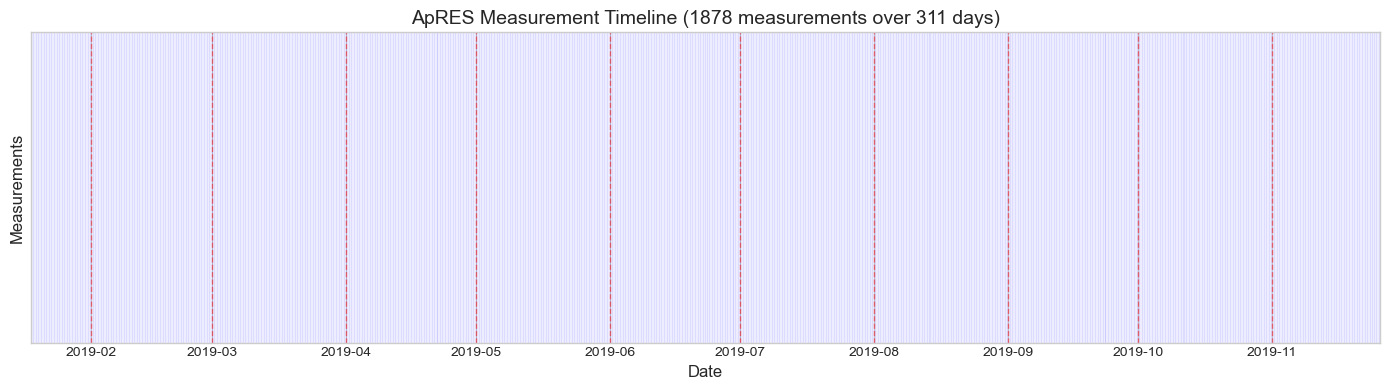

In [21]:
# Visualize temporal coverage
fig, ax = plt.subplots(figsize=(14, 4))

# Plot measurements as vertical lines
for i, d in enumerate(dates):
    ax.axvline(d, color='blue', alpha=0.1, linewidth=0.5)

# Highlight monthly boundaries
for month in range(1, 13):
    for year in [2019]:
        try:
            d = datetime(year, month, 1)
            if min(dates) <= d <= max(dates):
                ax.axvline(d, color='red', linestyle='--', alpha=0.5, linewidth=1)
        except:
            pass

ax.set_xlim(min(dates), max(dates))
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Measurements', fontsize=12)
ax.set_title(f'ApRES Measurement Timeline ({len(raw_files)} measurements over {(max(dates)-min(dates)).days} days)', fontsize=14)
ax.set_yticks([])

plt.tight_layout()
plt.show()

## 3. Visualize Range Over Time

The key output from ApRES processing is the change in range (distance) to internal ice reflectors over time. This can reveal:
- Ice thickness changes
- Vertical strain within the ice
- Response to lake drainage events

In [22]:
# Try to plot the main range-over-time data
# The exact plotting depends on what variables are available

# Common variable names in ApRES processing:
possible_time_vars = ['time', 't', 'Time', 'datenum', 'dates']
possible_range_vars = ['range', 'Range', 'r', 'depth', 'Depth', 'h', 'thickness']
possible_data_vars = ['data', 'Data', 'amp', 'Amp', 'amplitude', 'rangeChange', 'dh']

# Find what we have
available_vars = [k for k in apres_data.keys() if not k.startswith('_')]
print("Available variables:", available_vars)

# Try to identify and plot
for var in available_vars:
    data = apres_data[var]
    if hasattr(data, 'shape') and len(data.shape) >= 1:
        print(f"\n{var}: shape = {data.shape}")

Available variables: ['range', 'timeInDays']

range: shape = (181, 1)

timeInDays: shape = (181, 1)


Found 2D data: range with shape (181, 1)


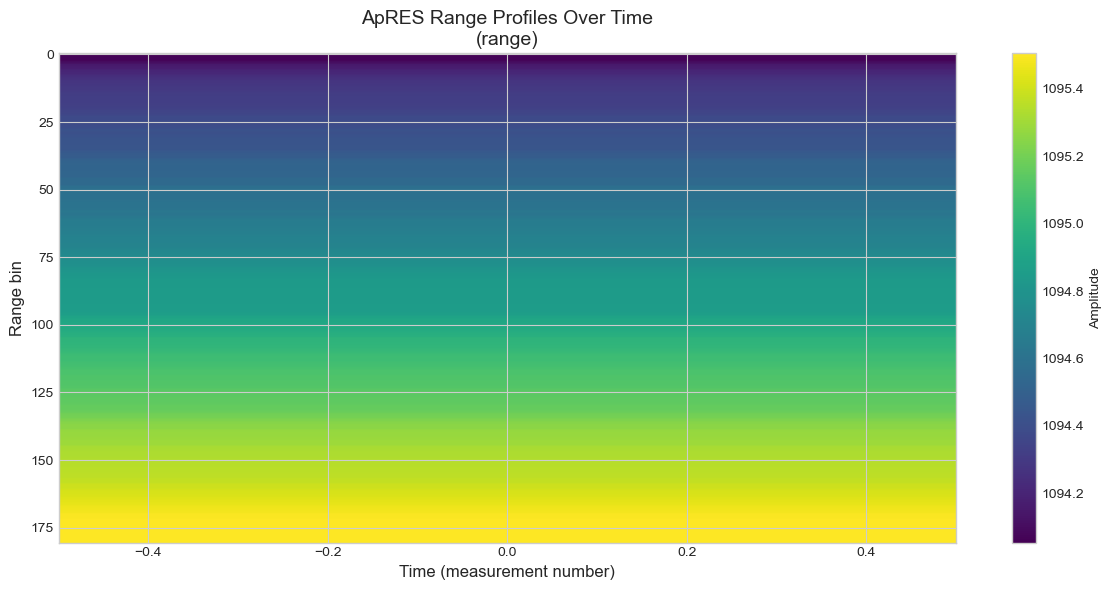

In [23]:
# Attempt to visualize the data based on what's available
# This cell may need to be adjusted based on the actual variable names

available_vars = [k for k in apres_data.keys() if not k.startswith('_')]

# Find 2D data array (likely range profiles over time)
for var in available_vars:
    data = apres_data[var]
    if hasattr(data, 'shape') and len(data.shape) == 2:
        print(f"Found 2D data: {var} with shape {data.shape}")
        
        fig, ax = plt.subplots(figsize=(12, 6))
        
        # Plot as image
        im = ax.imshow(np.abs(data), aspect='auto', cmap='viridis')
        plt.colorbar(im, ax=ax, label='Amplitude')
        ax.set_xlabel('Time (measurement number)', fontsize=12)
        ax.set_ylabel('Range bin', fontsize=12)
        ax.set_title(f'ApRES Range Profiles Over Time\n({var})', fontsize=14)
        
        plt.tight_layout()
        plt.show()
        break

In [24]:
# Extract and visualize the range data properly
range_data = apres_data['range'].flatten()  # Range to reflector in meters
time_days = apres_data['timeInDays'].flatten()  # Time in days from start of 2019

# Convert days to actual dates (assuming day 1 = Jan 1, 2019)
start_date = datetime(2019, 1, 1)
dates_apres = [start_date + timedelta(days=float(d)) for d in time_days]

# Calculate range change relative to first measurement
range_change = (range_data - range_data[0]) * 1000  # Convert to mm

print(f"=== ApRES Range Measurements ===")
print(f"Number of measurements: {len(range_data)}")
print(f"Date range: {dates_apres[0].strftime('%Y-%m-%d')} to {dates_apres[-1].strftime('%Y-%m-%d')}")
print(f"\nInitial range to bed: {range_data[0]:.3f} m")
print(f"Final range to bed: {range_data[-1]:.3f} m")
print(f"Total change: {range_change[-1]:.1f} mm ({(range_data[-1]-range_data[0]):.3f} m)")

=== ApRES Range Measurements ===
Number of measurements: 181
Date range: 2019-02-17 to 2019-11-25

Initial range to bed: 1094.054 m
Final range to bed: 1095.505 m
Total change: 1451.4 mm (1.451 m)


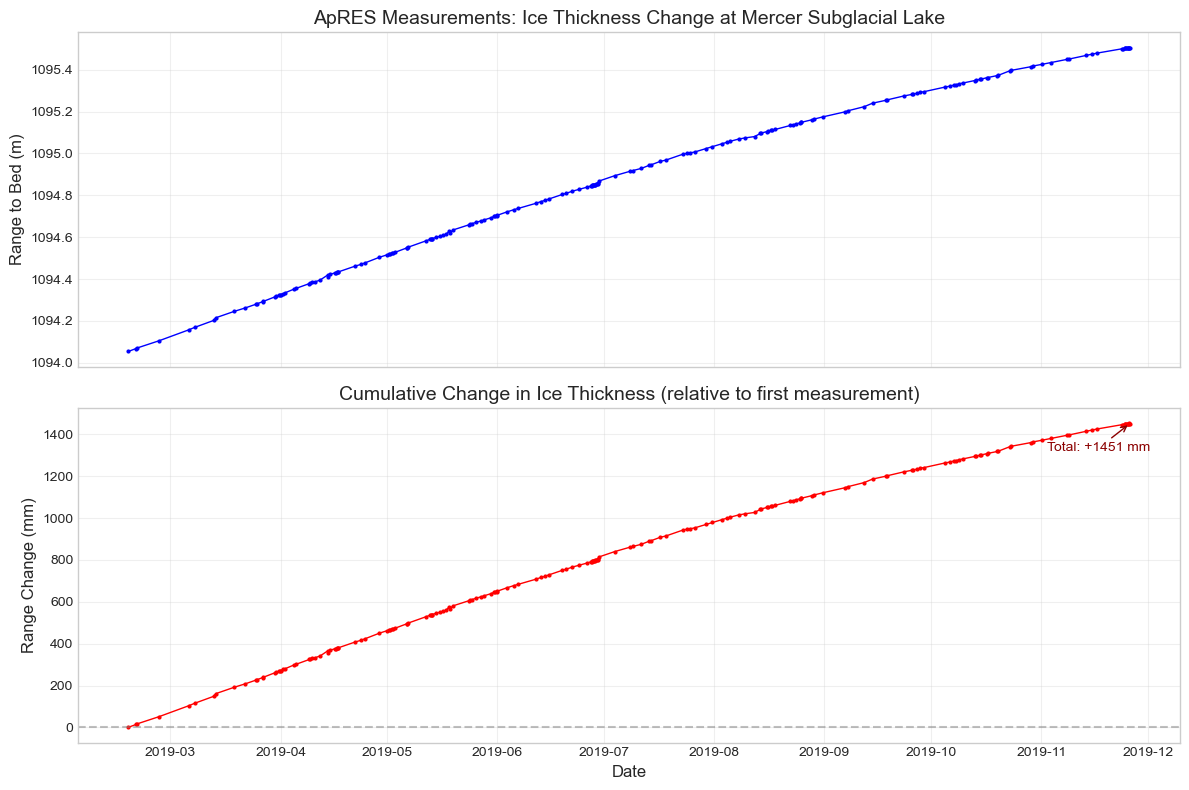


Average rate of thickness change: 1885.3 mm/yr


In [25]:
# Visualize range change over time
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Plot absolute range
axes[0].plot(dates_apres, range_data, 'b.-', markersize=4, linewidth=1)
axes[0].set_ylabel('Range to Bed (m)', fontsize=12)
axes[0].set_title('ApRES Measurements: Ice Thickness Change at Mercer Subglacial Lake', fontsize=14)
axes[0].grid(True, alpha=0.3)

# Plot range change in mm
axes[1].plot(dates_apres, range_change, 'r.-', markersize=4, linewidth=1)
axes[1].axhline(0, color='gray', linestyle='--', alpha=0.5)
axes[1].set_xlabel('Date', fontsize=12)
axes[1].set_ylabel('Range Change (mm)', fontsize=12)
axes[1].set_title('Cumulative Change in Ice Thickness (relative to first measurement)', fontsize=14)
axes[1].grid(True, alpha=0.3)

# Add annotation for final change
axes[1].annotate(f'Total: +{range_change[-1]:.0f} mm', 
                 xy=(dates_apres[-1], range_change[-1]),
                 xytext=(-60, -20), textcoords='offset points',
                 fontsize=10, color='darkred',
                 arrowprops=dict(arrowstyle='->', color='darkred'))

plt.tight_layout()
plt.show()

# Calculate rate of change
total_days = (dates_apres[-1] - dates_apres[0]).days
rate_mm_per_year = range_change[-1] / total_days * 365
print(f"\nAverage rate of thickness change: {rate_mm_per_year:.1f} mm/yr")

## 4. Understanding Raw ApRES Data Format

The raw `.DAT` files contain FMCW (Frequency Modulated Continuous Wave) radar data. Let's peek at one file to understand the format.

In [26]:
# Read header from first raw file
if raw_files:
    first_file = raw_files[0]
    print(f"Examining: {os.path.basename(first_file)}")
    print(f"File size: {os.path.getsize(first_file) / 1024:.1f} KB")
    
    # Try to read first few bytes to see format
    with open(first_file, 'rb') as f:
        header = f.read(500)  # Read first 500 bytes
        
    # Try to decode as ASCII (ApRES headers are typically text)
    try:
        # Look for printable ASCII
        ascii_text = ''.join(chr(b) if 32 <= b < 127 or b in [10, 13] else '.' for b in header)
        print("\nHeader (ASCII):")
        print(ascii_text[:400])
    except:
        print("Binary data (not ASCII header)")

Examining: DATA2019-01-18-0231.DAT
File size: 12504.4 KB

Header (ASCII):

*** Burst Header ***
Time stamp=2019-01-18 02:31:26
RMB_Issue=2c
VAB_Issue=C
SW_Issue=102.8
Venom_Issue=20150630
NSubBursts=40
NData=0
Triples=0,0,0,0,0,0,0,0,0,0,0,0
Average=0
RepSecs=3600
CheckEthernet=1
N_ADC_SAMPLES=40001
MAX_DATA_FILE_LENGTH=10000000
ANTENNA_SELECT=0
nAttenuators=1
Housekeeping=0
GPSon=10
SyncGPS=0
Iridium=0
WATCHDOG_TASK_SECS=3600
IntervalMode=0
Inter


## 5. Summary

The ApRES data in this repository captures ~10 months of phase-sensitive radar measurements at Mercer Subglacial Lake. Key points:

- **Temporal coverage**: January - November 2019
- **Sampling interval**: ~4 hours
- **Purpose**: Track ice thickness changes and detect lake drainage events
- **Processing**: Raw FMCW data → range profiles → range-over-time analysis

The MATLAB processing code in `proc/apres/` converts the raw radar bursts into range estimates that can be compared over time to detect:
1. Basal melting or refreezing
2. Surface accumulation
3. Ice vertical strain
4. Lake level changes (affecting the ice-water interface)

In [27]:
# Final summary statistics
print("=== ApRES Data Summary ===")
print(f"Raw files: {len(raw_files)}")
print(f"Date range: {min(dates).strftime('%Y-%m-%d')} to {max(dates).strftime('%Y-%m-%d')}")
print(f"Duration: {(max(dates) - min(dates)).days} days")
print(f"Average sampling: {np.mean(intervals):.1f} hours")
print(f"\nProcessed data available: rangeOverTime.mat")
print(f"Variables: {[k for k in apres_data.keys() if not k.startswith('_')]}")

=== ApRES Data Summary ===
Raw files: 1878
Date range: 2019-01-18 to 2019-11-25
Duration: 311 days
Average sampling: 4.0 hours

Processed data available: rangeOverTime.mat
Variables: ['range', 'timeInDays']
